In [3]:
!pip install accelerate


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


torch.Size([1, 3, 128, 128])
Generated image saved as 'generated_images/generated.png'
CLIP Score: 0.2430


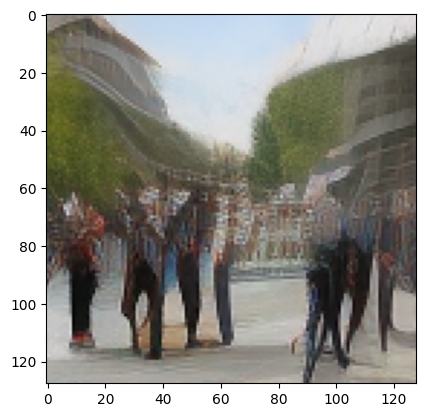

In [7]:
import torch
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel,CLIPModel
from PIL import Image
import numpy as np
import torch.nn.functional as F
import os
from torchvision.transforms import transforms
from huggingface_hub import snapshot_download

def generate_image_with_clip_score(prompt, num_inference_steps=50, guidance_scale=7.5):

    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device='cpu'
    
    # Load models

# Only download epoch_4
    # model_path = snapshot_download(
    #     repo_id="vish26/latent-diffusion-model-64x64",
    #     repo_type="model",
    #     allow_patterns=["epoch_4/*"]
    # )
    LATENT_SIZE = 16
    model_path = '/teamspace/studios/this_studio/Latent-Diffusion-Model-for-text-to-image-generation/ldm_checkpoints'
    model_path = os.path.join(model_path, "epoch_6")
    
    # Initialize models
    unet = UNet2DConditionModel.from_pretrained(
        os.path.join(model_path, "unet"),
        use_safetensors=True
    ).to(device)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
    scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
    clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    # Load training state if needed
    checkpoint = torch.load(os.path.join(model_path, "training_state.pth"), map_location=device)
    unet.load_state_dict(checkpoint['model_state_dict'])
    
    # Set to evaluation mode
    unet.eval()
    text_encoder.eval()
    vae.eval()
    
    # Encode text
    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    # Create uncond input for classifier-free guidance
    uncond_input = tokenizer(
        [""] * 1,  # Empty string for unconditional guidance
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids)[0]
        uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize random latents
    latents = torch.randn(
        (1, 4, LATENT_SIZE, LATENT_SIZE)  # Adjust dimensions to match training
    ).to(device)
    latents = latents * scheduler.init_noise_sigma
    
    # Denoising loop
    scheduler.set_timesteps(num_inference_steps)
    for t in scheduler.timesteps:
        # Expand latents for classifier-free guidance
        latent_model_input = torch.cat([latents] * 2)
        
        # Scale latents according to timestep
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        # Predict noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            ).sample
        
        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Decode latents to image
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    print(image.shape)
    
    image = (image / 2 + 0.5).clamp(0, 1)
    image_tensor = image.detach().cpu()
    image = image_tensor.permute(0, 2, 3, 1).squeeze(0).numpy()  # Convert to shape [512, 512, 3]
    image = (image * 255).round().astype("uint8")
    
    image = Image.fromarray(image)

    
    # Calculate CLIP score
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    processed_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip.get_image_features(processed_image)
        image_features = F.normalize(image_features, dim=-1)
        
        text_features = clip.get_text_features(text_input.input_ids)
        text_features = F.normalize(text_features, dim=-1)
        clip_score = (image_features * text_features).sum(dim=-1).item()
    
    return image, clip_score

# Example usage
prompt = "people walking on street"
generated_image, clip_score = generate_image_with_clip_score(prompt)
os.makedirs("generated_images", exist_ok=True)
generated_image.save("generated_images/generated.png")
print(f"Generated image saved as 'generated_images/generated.png'")
plt.imshow(generated_image)
print(f"CLIP Score: {clip_score:.4f}")